In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from  matplotlib import ticker
import seaborn as sns
import pickle
from os import path

In [2]:
# ! pip install --user seaborn

In [3]:
from faraday_rotation import Target
from faraday_rotation import Simulation
from faraday_rotation import Configuration
from faraday_rotation import Detection

# Introduction
This notebook can be used for testing various experimental setups in an x-ray polarimetry experiment using Faraday rotation.

In such an experiment a previously linearly polarized beam travels through an optically active sample.
Due to the circular birefringence of the material the original polarization changes after passing through the sample. 
The change in the polarization direction can than be obtained, by placing an analyzer in front of the detector and comparing with a reference measurement (no analyzer). This can be used to obtain information about the structure of the magnetic fields in a plasma (as soon as the electron density is already known), since the Faraday rotation effect in plasma depends on the magnetic field: 

$$ \phi = \frac{e_o}{2 c m_e}\int_S  \frac{n_e}{n_c} \mathbf{B} \cdot \mathbf{\hat{k}} \ \mathrm{d}s % Factor is missing$$ 

$n_e$ - electron density, $\mathbf{B}$ - B-field, $S$ - x-ray propagation path , $\phi$ - rotation angle

$n_c(\lambda) = m_e\varepsilon_0(\frac{2\pi c}{e \lambda})^2$ -electron critical density

The rotation can be calculated, by integrating over the simulation output data, but this script uses an already calculated rotation. It can be provided as a text file or a numpy binary file (*.npy). 

# Setup.
## Target.
At first some parameters regarding the simulation and the target (grid size, target position, target transmission) have to be set:

In [4]:
# target settings:
target_settings = {
    'trans': 0.72 # target transmission
}

In [5]:
# simulation settings:
simulation_settings = {
    'ta_x_s': 0,  # start position in x direction, in micron
    'ta_x_e': 7.2,  # end position in x direction, in micron
    'ta_y_s': -13.5,  # start in y direction, in micron
    'ta_y_e': 13.5,  # end in y direction, in micron
    'm': 1801,  # Nx: grid number in x direction
    'n': 6040,  # Ny: grid number if y direction, MUST be an even number
    'energy': 6.457  # Photon energy in keV used while calculating rotation.
}

simulation = Simulation(Target(**target_settings), **simulation_settings)

In [6]:
%%HTML
<style>
    figure {
    display: block;
    margin-top: 2em;
    margin-bottom: 2em;
    margin-left: 40px;
    margin-right: 40px;
}
</style>

## Experimental setup.
Now some parameters for the synthetic experiment have to be chosen.

Further explanation for some of the variables:

- The analyzer position (`an_position`) is defined as its variation from the position providing the maximal extinction. That means, when `an_position` is set to zero, the transmission axis is at an $\frac{\pi}{2}$ angle to the primary beam polarization direction. (See the graphic below.)

- Polarization impurity (`an_extinction`) is the percentage of the photons remaining polarized perpendicularly to the main polarization of the incoming beam.  
- `det_beam_width` is the beam width at the detector. 
- Magnification (`m`) is the ratio of the target projection at the detector to the actual target size.

<!-- Some exemplary values for different CLRs setups and targets:-->
<!--
<table>
	<tr>
    	<th>target type</th>
        <th>setup</th>
        <th>magnification</th>
    </tr>
</table> 
-->

<center>
    <figure>
        <img src="images/angles.png" width = "35%">
        <figcaption><b>Figure 1</b> Definition of the angles.</figcaption>
    </figure>
</center>

In [7]:
# optical setup:

#Transmission of all channelcuts including spectral bandwidth.
trans_channel = 0.43*0.6/0.8 # max trans*BW_cc/BW_lcls

config_settings = {
    'an_position': -10, # analyzer position (mrad)
    'impurity': 1e-5,  # polarization impurity (1 = 100%)
    'an_extinction': 2e-7,  # analyzer extinction (1 = 100%)
    'det_obs_energy': 6.457, # observation energy in keV
    'det_trans_channel': trans_channel, # as above
    'det_pixel_size': 13,  # pixel size in micrometer (detector)
    'det_beam_width': 320,  # beam_width in micrometer 320
    'n_0': 1e12,  # initial number of photons
    'm': 30,  # magnification
    'trans_telescope': 1  # Transmission of CRLs due to beam size
        # mismatch (asymmetry).
}

config = Configuration(**config_settings)

## Loading the rotation data.
From a text file (with `genfromtext` from `numpy`):

In [9]:
#load simulation data:
# path_to_file = '/home/pawel/Work/TEAM/fwt/members/hs5955/Faraday Rotation/MEC_Ti/Rotation_16.dat'
# simulation.load_data(path=path_to_file)

It can be saved as a binary file,

In [12]:
# Uncomment & execute for saving.
# save_dir = '../../data/polarimetry'
# file_name = 'sim'
# np.save(path.join(save_dir, file_name), simulation.data)

In [ ]:
# Maybe write as an hpy5 file in the openPMD format.
# A way of a nice integration with the notebook for calculating rotation.

or loaded from it.

In [ ]:
simulation.data = np.load(path.join(save_dir, file_name + '.npy'))

# Experiment.
With all the parameters set up, the experiment can now be simulated. 

In [13]:
experiment = Detection(config, simulation)

Above, a separate observation energy `det_obs_energy`, could be set. 
The predicted values of the Faraday rotation where calculated for a given photon-energy of the probing beam.
The rotation is proportional to the the wave length squared, so the effect can be easily scaled. In the next line the data is fitted to the new observation energy. 

In [14]:
experiment.calc_rotation()

The next line creates a detector of the size of the target projection with a spatial resolution determined by the given magnification and pixel size. 

In [15]:
experiment.calc_det_shape()

Calculating the transmission through the analyzer for every cell. The analyzer extinction and the polarization impurity are taken into consideration. The obtained intensity profile is then scaled to the detector size and resolution. 

In [16]:
experiment.emulate_intensity()

The amount of photons on the axis hast to be estimated. It has been previously calculated for a specific CRL (which?) configuration. Now it's rescaled for the chosen initial number of photons `n_o` and the pixel size `det_pixel_size`.

If desired, a different value, from a new calculation, can be specified here. Use `?` for more details (uncomment & execute the following line of code):

In [17]:
# Detection.calc_ph_per_px_on_axis?

In [18]:
experiment.cfg.calc_ph_per_px_on_axis()

160000000.0

Generating beam profile. It's Gaussian with the standard deviation squared equal to the beam width over the pixel size. 

In [19]:
experiment.calc_beam_profile(x_y_ratio=1)

Finally the intensity changes due to passing through the polarizer are applied to the beam profile.

In [20]:
experiment.ideal_detector = experiment.beam_profile*experiment.intensity_px

## Noise and noise accumulation.

For more realistic output some noise is added. To make the data usable again, it is possible to generate images with a different random noise and accumulate them. This can help with estimating, how many single measurements will be needed. 

In [21]:
# A noisy image without accumulation. For comparison. 
exp_with_noise = experiment.add_noise(accumulation=1)

In [22]:
# This generates an image integrated over noisy images.
accumulation = 30
exp_noise_acc = experiment.add_noise(accumulation=accumulation) 

The same thing can be done for the reference image. 

In [23]:
base_noise_acc = experiment.add_noise(accumulation=accumulation,
                                      image=experiment.beam_profile)


## Threshold.
To avoid artifacts occurring due to the bad statistic on pixels far away from the beam center, it is possible to set a threshold for the number of accumulated photons, from which the data would be used in further calculations. 

The threshold can be applied either on the output of the reference experiment (default), or the experiment with the polarizer.


In [24]:
# Choose if (and where) the threshold should be applied.
threshold_on = True
threshold_based_on_reference = True  # otherwise the other output.

In [25]:
if threshold_based_on_reference & threshold_on == True:  
    # choose the threshold:
        # The maximal difference in order of magnitute, beetwen the overall
        # intitall photon number and the accepted value:
    diff_in_order = 4 
    threshold1 = 10 ** -diff_in_order *experiment.cfg.n_0
    
    print(("Threshold is {:.3e} photons and it's applied"
          "to the base line.").format(threshold1))
    # Feel free to overwrite with  your own threshold value.
    # threshold1 = ...
    
    # mark the invalid data points:
    cut_off_base_noise_acc = np.ma.masked_less(base_noise_acc, threshold1)
    cut_off_exp_noise_acc = exp_noise_acc  # stays unchanged.
    
elif threshold_on:
    # set the threshold:
    threshold2= 30 * 100
    print(("Threshold is {:.3e} photons and it's applied" 
          " to the outcome with the polarizer.").format(threshold2))

    cut_off_exp_noise_acc = np.ma.masked_less(exp_noise_acc, threshold2)
    # rule out zeros in the reference output,to avoid division by zero. 
    cut_off_base_noise_acc = np.ma.masked_equal(base_noise_acc, 0)

Threshold is 1.000e+08 photons and it's appliedto the base line.


## Reobtaining the Faraday rotation.

A the end, the rotation can be obtained, pixel wise, from the generated image, by reversing the previous calculation. 

In [26]:
if threshold_on == True:
    rot = experiment.reobtain_rotation(cut_off_exp_noise_acc,
                                       cut_off_base_noise_acc)
else:
    rot = experiment.reobtain_rotation(exp_noise_acc, base_noise_acc)

# Outcome.
## Plots.
### Setup.

In [27]:
%matplotlib inline

In [28]:
# generate matplotlib cmaps with seaborn:
cmap_rotation_all = sns.diverging_palette(240, 10, s=85, l=30, n=256 ,
                                          center = 'light',
                                          as_cmap=True)
cmap_rotation_extrema = sns.diverging_palette(240, 10, s=85, l=30, n=256 ,
                                              sep=60, center = 'light',
                                              as_cmap=True)
cmap_beam_profile = sns.cubehelix_palette(256, start=0.5, rot=-0.6, dark=0.15,
                                          light=0.9, reverse=True,
                                          as_cmap=True)

# set color of the pixels marked as invalid. 
# Doesn't affect anything, if the threshold is used. 
for cmap in [cmap_rotation_all, cmap_rotation_extrema]:
    cmap.set_bad('white')

In [29]:
# Specify tittles for the plotts:
rotation_tittle = 'Faraday rotation \n (Input data).\n'
    
intensity_px_tittle = ('Transmission through polarizer \n' 
                        'at {} mrad with {:.2e} extinction \n'
                        'and {:.2e} impurity.\n'
                        ).format(experiment.cfg.an_position,
                                experiment.cfg.an_extinction,
                                experiment.cfg.impurity)
                                                
re_rot_tittle = ('Reconstructed map of Faraday rotation. \n'
                  'Integration of {} shots.\n'
                  '(White - below threshold.)\n'
                  ).format(accumulation)

base_noise_acc_tittle = ('Reference image.\n'
                         'Integration of {} shots \n').format(accumulation)
exp_with_noise_tittle = 'Noisy signal, with polarizer. \n No accumulation\n'
exp_noise_acc_tittle = ('Main signal (with polarizer)\n'
                       'Integration of {} shots\n.'
                        ).format(accumulation)


In [32]:
# Image boundaries, used for correct ticks labeling:
edges = (experiment.sim.ta_x_s, experiment.sim.ta_x_e,
         experiment.sim.ta_y_s, experiment.sim.ta_y_e)

In [33]:
def plot_rot(cmap, figsize, edges, rotation=None, rotation_tittle=None,
             intensity_px=None, intensity_px_tittle=None,
             re_rot=None, re_rot_tittle=None):
    
    n_plots = 0 
    # Check how meany plots are plotted:
    if rotation is not None:
        n_plots += 1
    if intensity_px is not None:
        n_plots += 1 
    if re_rot is not None:
        n_plots += 1
    
    if n_plots == 0:
        return 0

    # Generate subplots:
    rot_fig, axis = plt.subplots(1, n_plots, figsize=figsize)
     
    # Symmetric norm, same for input and output data (when both are plotted).
    if rotation is not None and re_rot is not None:
        v_max = max([abs(np.min(rotation)), abs(np.min(re_rot)),
                 abs(np.max(rotation)), abs(np.max(re_rot))])
        norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
        
    elif rotation is not None:
        v_max = max([abs(np.min(rotation)), abs(np.max(rotation))])
        norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
                     
    elif re_rot is not None:
        v_max = max([abs(np.min(re_rot)), abs(np.max(re_rot))])
        norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
    
    c_bars = [None] * n_plots

    # PLoting and setting color bars and descritpions:
    if rotation is not None:
        axis[0].set_title(rotation_tittle)
        axis[0].imshow(rotation, extent=edges, cmap=cmap, norm=norm)
        c_bars[0] = rot_fig.colorbar(axis[0].images[0], ax = axis[0])
        c_bars[0].ax.set_title('[mrad]')
                     
        if  intensity_px is not None:
            axis[1].set_title(intensity_px_tittle)
            axis[1].imshow(intensity_px, extent=edges, cmap=cmap)
            c_bars[1] = rot_fig.colorbar(axis[1].images[0], ax = axis[1],
                                 format=ticker.StrMethodFormatter('{x:.2e}'))
        
            if re_rot is not None:
                axis[2].set_title(re_rot_tittle)
                axis[2].imshow(re_rot, extent=edges, cmap=cmap, norm=norm)
                c_bars[2] = rot_fig.colorbar(axis[2].images[0], ax = axis[2])     
                c_bars[2].ax.set_title('[mrad]')          
                
        elif re_rot is not None:
            axis[1].set_title(re_rot_tittle)
            axis[1].imshow(re_rot, extent=edges, cmap=cmap, norm=norm)
            c_bars[1] = rot_fig.colorbar(axis[1].images[0], ax = axis[1])     
            c_bars[1].ax.set_title('[mrad]')
    elif intensity_px is not None:
        axis[1].set_title(intensity_px_tittle)
        axis[1].imshow(intensity_px, extent=edges, cmap=cmap)
        c_bars[0] = rot_fig.colorbar(axis[0].images[0], ax = axis[0],
                                 format=ticker.StrMethodFormatter('{x:.2e}'))            
        if re_rot is not None:
            axis[1].set_title(re_rot_tittle)
            axis[1].imshow(re_rot, extent=edges, cmap=cmap, norm=norm)
            c_bars[1] = rot_fig.colorbar(axis[1].images[0], ax = axis[1])     
            c_bars[1].ax.set_title('[mrad]')     
    else:
        axis[0].set_title(re_rot_tittle)
        axis[0].imshow(re_rot, extent=edges, cmap=cmap, norm=norm)     
        c_bars[0] = rot_fig.colorbar(axis[0].images[0], ax = axis[0])           
        c_bars[0].ax.set_title('[mrad]')
    
    # Some extra settings for the ticks.
    for ax in axis:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto',
                                                      prune=None))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto',
                                                      prune=None))

    plt.tight_layout()  
    
    return rot_fig

In [34]:
def plot_det(cmap, figsize, edges, base_noise_acc, base_noise_acc_tittle,
         exp_with_noise, exp_with_noise_tittle, exp_noise_acc, 
             exp_noise_acc_tittle):
    
    exp_fig, axis = plt.subplots(1, 3, figsize=figsize)


    axis[0].set_title(base_noise_acc_tittle)
    axis[1].set_title(exp_with_noise_tittle)
    axis[2].set_title(exp_noise_acc_tittle)
    # Image boundaries, used for correct ticks labeling:

    axis[0].imshow(base_noise_acc, extent=edges, cmap=cmap)
    axis[1].imshow(exp_with_noise, extent=edges, cmap=cmap)
    axis[2].imshow(exp_noise_acc, extent=edges, cmap=cmap)
    
    c_bars = [None] * 3
    for ax in axis:
        # Add colorbars:
        exp_fig.colorbar(ax.images[0], ax = ax, format = ticker.StrMethodFormatter('{x:.1e}'))
    plt.tight_layout() 
    
    return exp_fig

### Plotting.
Figures can be plotted with any of the following subplots :
 - input rotation,
 - analyzer profile,
 - reobtained rotation.
  
 Set the corresponding optional arguments(`rotation`,`intensity_px`,`re_rot`), when calling the `plot_rot` function:
 

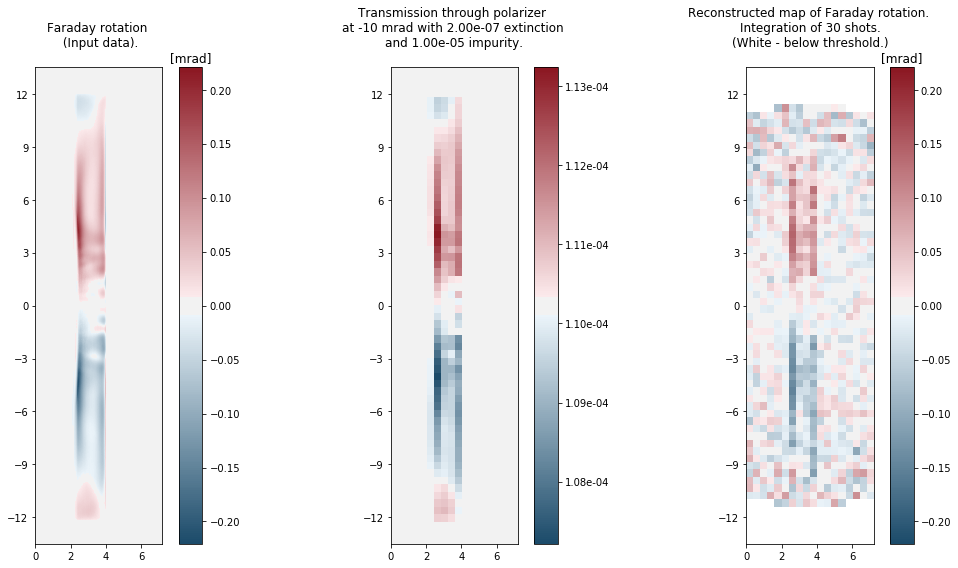

In [35]:
rot_fig = plot_rot(cmap_rotation_all, (15,8), edges,
                   rotation=experiment.rotation,
                   rotation_tittle = rotation_tittle,
                   intensity_px=experiment.intensity_px,
                   intensity_px_tittle=intensity_px_tittle,
                   re_rot=rot,
                   re_rot_tittle=re_rot_tittle)

Figures can be saved:

In [36]:
# rot_fig.savefig('rot.png')

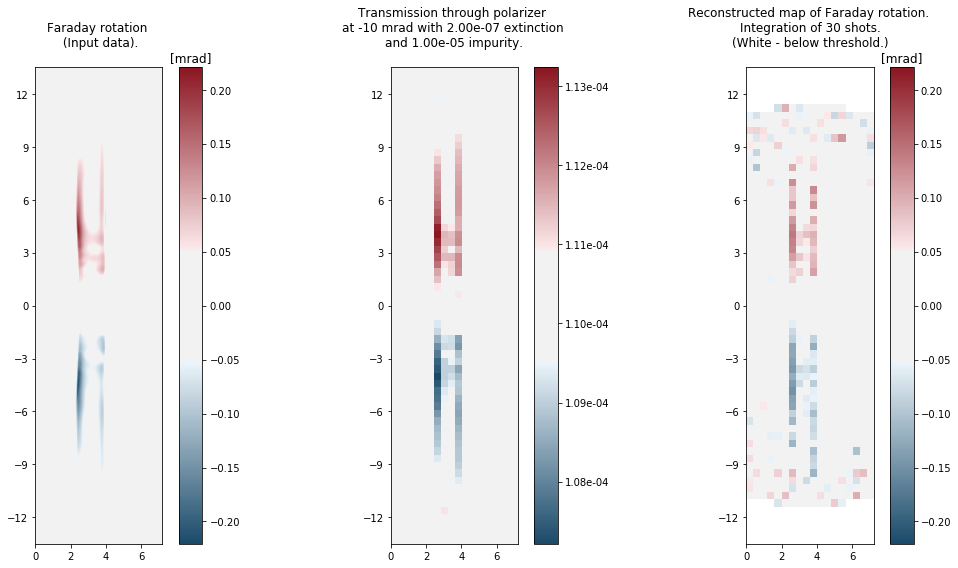

In [37]:
rot_fig = plot_rot(cmap_rotation_extrema, (15,8), edges,
                   rotation=experiment.rotation,
                   rotation_tittle = rotation_tittle,
                   intensity_px=experiment.intensity_px,
                   intensity_px_tittle=intensity_px_tittle,
                   re_rot=rot,
                   re_rot_tittle=re_rot_tittle)

Plotting detected signals:

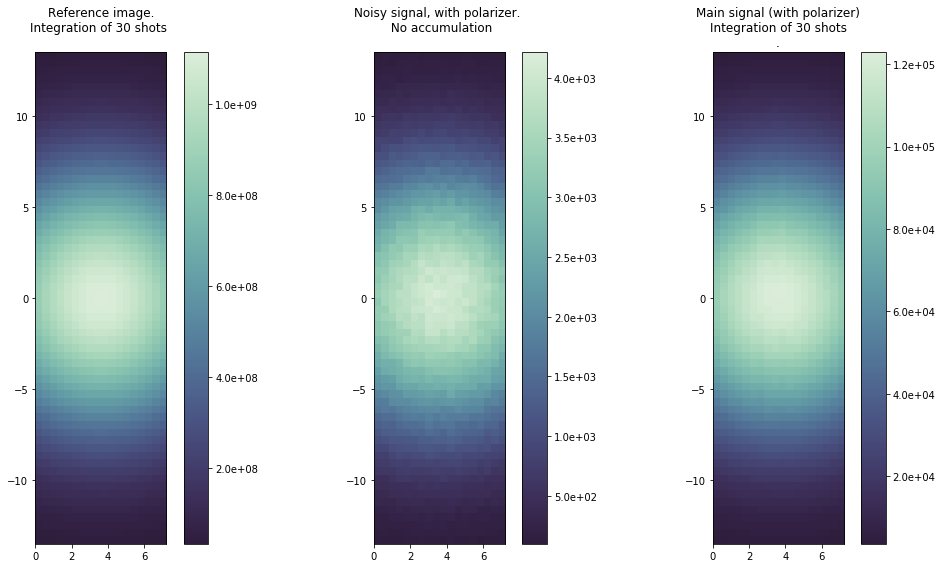

In [39]:
det_figure = plot_det(cmap_beam_profile, (15,8), edges, base_noise_acc,
                      base_noise_acc_tittle,
                      exp_with_noise, exp_with_noise_tittle,
                      exp_noise_acc, exp_noise_acc_tittle)

## Numerical output.